# Single-ancilla ground state preparation via Lindbladians

References:
- Zhiyan Ding, Chi-Fang Chen and Lin Lin  
  Single-ancilla ground state preparation:
  [arXiv:2308.15676 [quant-ph]](https://arxiv.org/abs/2308.15676)

## TFIM damping model, time independent Hamiltonian

In [2]:
import matplotlib.pyplot as plt
import qsimulations as qs
import numpy as np
from qutip import *

In [9]:

taylor_aprox_order = 8					# Taylor approximation used for simulating exp(-i*sqrt*(dt)*H_tilde)

g = 1 									# Couppling coefficient
gamma = 0.1 							# Damping parameter

systemSize = 2  						# System Hamiltonian
nrAncillas = 2							# Ancilla size
J = systemSize  						# Nr of jump operators is equal to the number of lattice elements
systemSize_dim = np.power(2, systemSize)# Hamiltonian system size


T = 5		  						# Final time
dt = 0.01  								# Time step
time_vec = np.arange(0, T, dt) 			# Time vector to simulate on

def H_op():
    H = np.zeros((systemSize_dim, systemSize_dim))
    if systemSize > 1:
        for i in np.arange(1, systemSize, 1):
            H = H - qs.Pauli_array(qs.Z, i, systemSize) @ qs.Pauli_array(qs.Z, i+1, systemSize)
        H = H - qs.Pauli_array(qs.Z, systemSize, systemSize) @ qs.Pauli_array(qs.Z, 1, systemSize)
    for i in np.arange(1, systemSize+1, 1):
        H = H - g * qs.Pauli_array(qs.X, i, systemSize)
    return H

def V_damping(i):
    if i == 0:
        sum = 0
        for j in np.arange(1, J + 1, 1):
            sum = sum + V_damping(j).full().conj().T @ V_damping(j).full()
        return Qobj(-1j * H_op() - 0.5 * sum)
    
    if i >= 1 and i <= systemSize_dim:
        return Qobj(
            0.5*(qs.Pauli_array(qs.X, i, systemSize) - 1j * qs.Pauli_array(qs.Y, i, systemSize))
        )
    return 0

QSystem = qs.qsimulations(H_op(), systemSize, systemSize, nrAncillas)
QSystem.V_op = V_damping

rho_ground = QSystem.rho_ground
rho_0 = QSystem.rho_0

/home/robi/Uni_stuff/QSimulations/qsimulations.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  self.psi_ground = np.matrix(eigenVectors[0].astype(float))
/home/robi/Uni_stuff/QSimulations/qsimulations.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  self.psi_0 = np.matrix(eigenVectors[-1].astype(float))


### Exact simulation


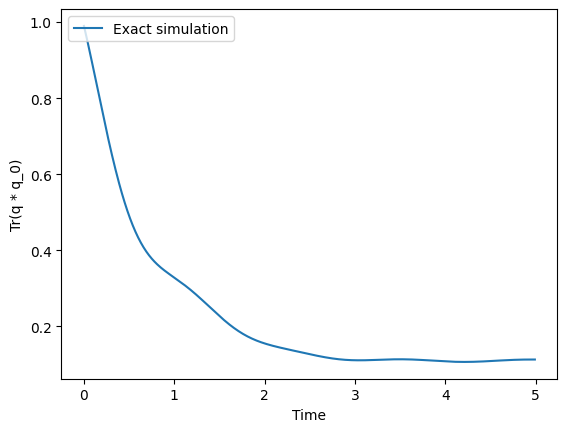

In [10]:
import matplotlib.pyplot as plt

rho = rho_0
exact_trace_rho_0 = []
for t in time_vec:
    sum = Qobj(np.zeros((QSystem._systemSizeDim, QSystem._systemSizeDim)))
    for j in np.arange(1, J + 1, 1):
        # Simple part
        sum = sum + QSystem.V_op(j) @ rho @ QSystem.V_op(j).conj().trans()
        # Anti-commuting part
        sum = sum - 0.5 * (
            QSystem.V_op(j).conj().trans() @ QSystem.V_op(j) @ rho
            + rho @ QSystem.V_op(j).conj().trans() @ QSystem.V_op(j)
        )
    delta_rho = -1j * (QSystem.H_op() @ rho - rho @ QSystem.H_op()) + sum
    rho = rho + dt * delta_rho
    exact_trace_rho_0.append((rho @ rho_0).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_0)")
plt.plot(time_vec, exact_trace_rho_0, label="Exact simulation")
plt.legend(loc="upper left")

### First order approximation

/home/robi/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


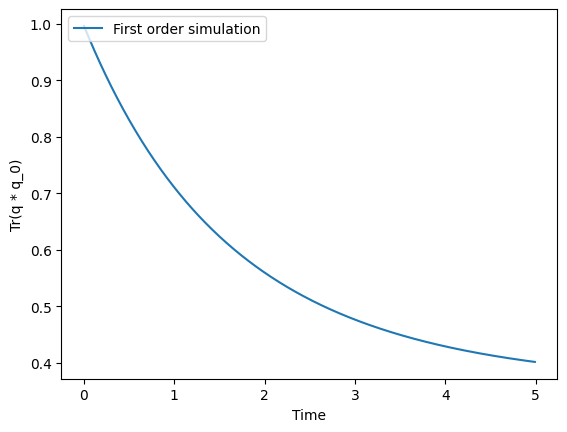

In [12]:
import math
import numpy as np

ancilla = 2  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = rho_0
first_order_trace_rho_0 = []
for t in time_vec:
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_first_order(dt), taylor_aproximation_order, np.sqrt(dt), approximation
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    first_order_trace_rho_0.append((rho @ rho_0).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_0)")
plt.plot(time_vec, first_order_trace_rho_0, label="First order simulation")
plt.legend(loc="upper left")

### Second order approximation

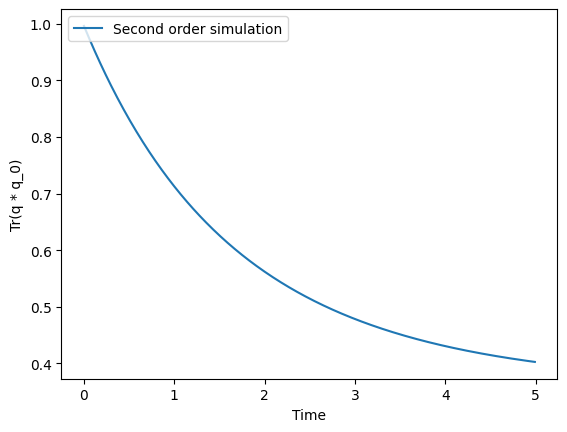

In [13]:
import math
import numpy as np

ancilla = 5  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = rho_0
second_order_trace_rho_0 = []
for t in time_vec:
    # print(t)
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_second_order(dt), taylor_aproximation_order, np.sqrt(dt), approximation
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    second_order_trace_rho_0.append((rho @ rho_0).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_0)")
plt.plot(time_vec, second_order_trace_rho_0, label="Second order simulation")
plt.legend(loc="upper left")

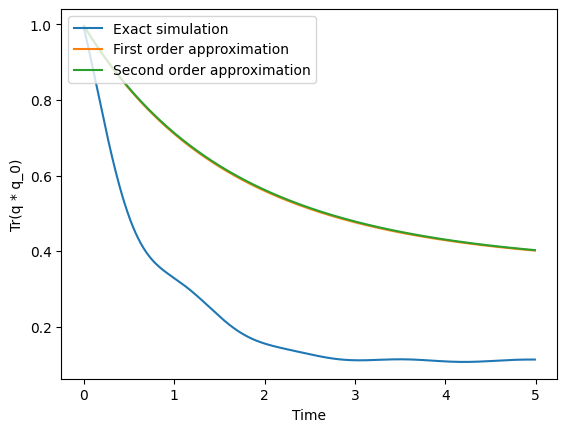

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_0)")
plt.plot(time_vec, exact_trace_rho_0, label="Exact simulation")
plt.plot(time_vec, first_order_trace_rho_0, label="First order approximation")
plt.plot(time_vec, second_order_trace_rho_0, label="Second order approximation")
plt.legend(loc="upper left")